<a href="https://colab.research.google.com/github/intimanjunath/Decision-trees-and-ensemble/blob/main/Random_Forest_Implementation_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [21]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=10, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return {"leaf": True, "value": leaf_value}

        # Select random features
        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # Find the best split
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)

        # Split the data
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return {"leaf": False, "feature": best_feat, "threshold": best_thresh, "left": left, "right": right}

    def _traverse_tree(self, x, node):
        if node["leaf"]:
            return node["value"]
        feature = node["feature"]
        threshold = node["threshold"]
        if x[feature] <= threshold:
            return self._traverse_tree(x, node["left"])
        return self._traverse_tree(x, node["right"])

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for thresh in thresholds:
                gain = self._information_gain(y, X_column, thresh)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = thresh

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y)

        # Generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # Weighted average child entropy
        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        e_left, e_right = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        # Information gain is difference in entropy
        return parent_entropy - child_entropy

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

In [22]:
class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=10, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                n_feats=self.n_feats
            )
            X_samp, y_samp = self.bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [self.most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

    @staticmethod
    def bootstrap_sample(X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    @staticmethod
    def most_common_label(y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

In [23]:
# Load dataset
cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
        "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
url = "https://gist.githubusercontent.com/ktisha/c21e73a1bd1700294ef790c56c8aec1f/raw/819b69b5736821ccee93d05b51de0510bea00294/pima-indians-diabetes.csv"
data = pd.read_csv(url, skiprows=9, header=None, names=cols)

# Prepare features and target
X = data[cols[:-1]].values
y = data[cols[-1]].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Accuracy: 0.74
Precision: 0.65
Recall: 0.56
F1-Score: 0.60


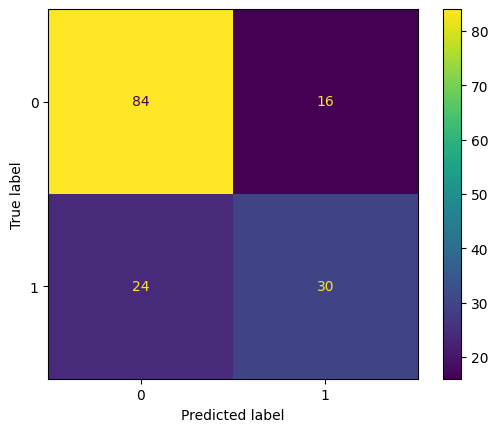

In [24]:
# Train Random Forest
rf = RandomForest(n_trees=10, max_depth=5, n_feats=4)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [ ]:
#In our implementation, each tree is created using the DecisionTree class.
#The RandomForest class manages multiple instances of the DecisionTree and combines their predictions.